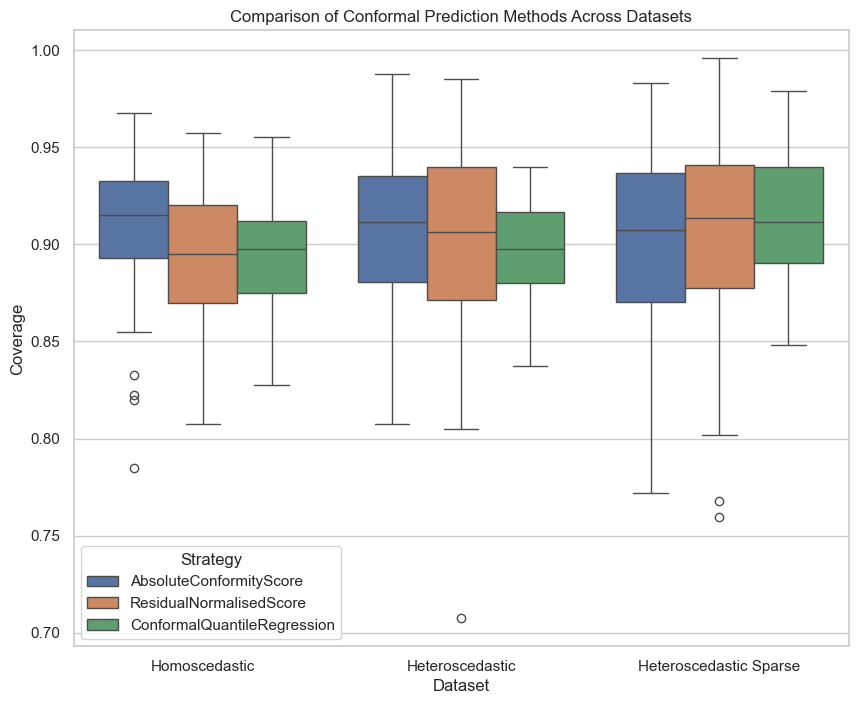

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from mapie.regression import MapieRegressor, MapieQuantileRegressor
from mapie.conformity_scores import AbsoluteConformityScore, ResidualNormalisedScore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from mapie.metrics import regression_coverage_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Fix random seed for reproducibility
np.random.seed(42)

# Define a function to generate homoscedastic data
def generate_homoscedastic_data(n, m, beta, sigma, noise_scale=5):
    """Generate data with constant variance."""
    X = np.random.uniform(0, 100, (n, m))
    epsilon = np.random.normal(0, 1, n)
    Y = X.dot(beta) + sigma * epsilon * noise_scale
    return X, Y

# Define a function to generate heteroscedastic data
def generate_heteroscedastic_data(n, m, beta, noise_scale=1):
    """Generate data with varying variance."""
    X = np.random.uniform(0, 100, (n, m))
    epsilon1 = np.random.normal(0, 1, n)
    epsilon2 = np.random.normal(0, 1, n)
    Z = X.dot(beta) + noise_scale * epsilon1
    Y = Z * (1 + noise_scale * epsilon2)
    return X, Y

# Define a function to generate sparse heteroscedastic data
def generate_heteroscedastic_sparse_data(n, m, beta, noise_scale=1):
    """Generate sparse data with varying variance."""
    X = np.random.uniform(0, 100, (n, m))
    mask_central = (X[:, 0] >= 25) & (X[:, 0] <= 75)
    mask_outer = (X[:, 0] < 25) | (X[:, 0] > 75)
    outer_indices = np.where(mask_outer)[0]
    keep_outer_indices = np.random.choice(outer_indices, size=int(len(outer_indices) * 0.2), replace=False)
    final_indices = np.concatenate([np.where(mask_central)[0], keep_outer_indices])
    X = X[final_indices]
    epsilon1 = np.random.normal(0, 1, X.shape[0])
    epsilon2 = np.random.normal(0, 1, X.shape[0])
    Z = X.dot(beta) + noise_scale * epsilon1
    Y = Z * (1 + noise_scale * epsilon2)
    return X, Y

# Data generation parameters
n = 1000   # Total samples
m = 1  # Number of features
beta = np.ones(m)  # Regression coefficients
sigma = 1.0  # Standard deviation for noise

# Generate different types of datasets
X1, Y1 = generate_homoscedastic_data(n, m, beta, sigma)
X2, Y2 = generate_heteroscedastic_data(n, m, beta, 0.2)
X3, Y3 = generate_heteroscedastic_sparse_data(n, m, beta, 0.2)
datasets = [(X1, Y1, 'Homoscedastic'), (X2, Y2, 'Heteroscedastic'), (X3, Y3, 'Heteroscedastic Sparse')]

# Function to train models and evaluate performance
def train_and_evaluate_mapie_models(X, Y, dataset_name, i):
    """Train models and compute evaluation metrics."""
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=i)
    results = []

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # MAPIE Regressor with Absolute Conformity Score
    mapie_absolute = MapieRegressor(estimator=model, cv="split", conformity_score=AbsoluteConformityScore())
    mapie_absolute.fit(X_train, y_train)
    y_pred_abs, y_pis_abs = mapie_absolute.predict(X_test, alpha=0.1)
    mse_abs = mean_squared_error(y_test, y_pred_abs)
    r2_abs = r2_score(y_test, y_pred_abs)
    coverage_abs = regression_coverage_score(y_test, y_pis_abs[:, 0], y_pis_abs[:, 1])
    avg_width_abs = np.mean(y_pis_abs[:, 1] - y_pis_abs[:, 0])
    results.append((dataset_name, 'AbsoluteConformityScore', mse_abs, r2_abs, coverage_abs, avg_width_abs))

    # MAPIE Regressor with Residual Normalised Score
    mapie_normalized = MapieRegressor(estimator=model, cv="split", conformity_score=ResidualNormalisedScore())
    mapie_normalized.fit(X_train, y_train)
    y_pred_norm, y_pis_norm = mapie_normalized.predict(X_test, alpha=0.1)
    mse_norm = mean_squared_error(y_test, y_pred_norm)
    r2_norm = r2_score(y_test, y_pred_norm)
    coverage_norm = regression_coverage_score(y_test, y_pis_norm[:, 0], y_pis_norm[:, 1])
    avg_width_norm = np.mean(y_pis_norm[:, 1] - y_pis_norm[:, 0])
    results.append((dataset_name, 'ResidualNormalisedScore', mse_norm, r2_norm, coverage_norm, avg_width_norm))

    # Conformal Quantile Regression
    quantile_model = QuantileRegressor(quantile=0.5, solver='highs')
    mapie_cqr = MapieQuantileRegressor(estimator=quantile_model, cv="split", alpha=0.1)
    mapie_cqr.fit(X_train, y_train)
    y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_test)
    mse_cqr = mean_squared_error(y_test, y_pred_cqr)
    r2_cqr = r2_score(y_test, y_pred_cqr)
    coverage_cqr = regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0])
    avg_width_cqr = np.mean(y_pis_cqr[:, 1, 0] - y_pis_cqr[:, 0, 0])
    results.append((dataset_name, 'ConformalQuantileRegression', mse_cqr, r2_cqr, coverage_cqr, avg_width_cqr))

    return results

# Execute the experiment multiple times to gather results
all_results = []
for i in range(50):
    for X, Y, dataset_name in datasets:
        results = train_and_evaluate_mapie_models(X, Y, dataset_name, i)
        all_results.extend(results)

# Convert all results to a DataFrame for analysis and visualization
results_df = pd.DataFrame(all_results, columns=['Dataset', 'Strategy', 'MSE', 'R2', 'Coverage', 'AvgWidth'])

# Plotting the results using Seaborn
plt.figure(figsize=(10, 8))
sns.boxplot(x='Dataset', y='Coverage', hue='Strategy', data=results_df)
plt.title('Comparison of Conformal Prediction Methods Across Datasets')
plt.show()


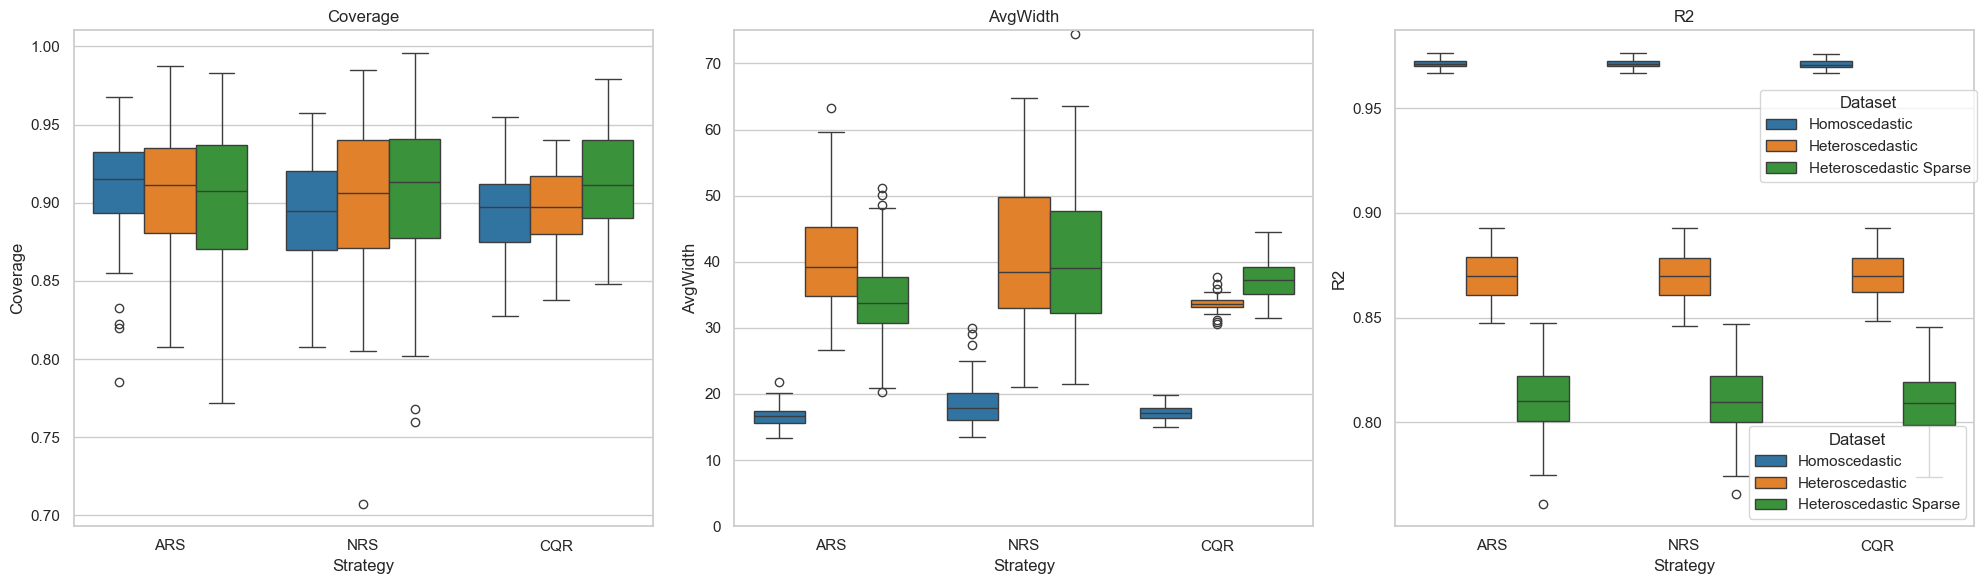

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set default Seaborn style for cleaner plots
sns.set(style="whitegrid")

# Define specific colors for each dataset to improve plot readability
colors = {
    'Homoscedastic': '#1f77b4',
    'Heteroscedastic': '#ff7f0e',
    'Heteroscedastic Sparse': '#2ca02c'
}

# Rename strategies for better clarity in plots
strategy_rename_map = {
    'AbsoluteConformityScore': 'ARS',
    'ResidualNormalisedScore': 'NRS',
    'ConformalQuantileRegression': 'CQR'
}

# Assume results_df is pre-defined with appropriate data
results_df['Strategy'] = results_df['Strategy'].replace(strategy_rename_map)

# List of metrics to be plotted
metrics = ['Coverage', 'AvgWidth', 'R2']

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loop through the metrics and create a boxplot for each
for i, metric in enumerate(metrics):
    sns.boxplot(
        x='Strategy', 
        y=metric, 
        hue='Dataset', 
        data=results_df, 
        palette=colors, 
        ax=axes[i], 
        dodge=True
    )
    axes[i].set_title(f'{metric}')
    axes[i].set_xlabel('Strategy')
    axes[i].set_ylabel(metric)
    
    # Customizing the y-axis scale for 'AvgWidth' to ensure the plot is informative
    if metric == 'AvgWidth': 
        axes[i].set_ylim([0, 75])

    # Remove the legend from individual plots to avoid redundancy
    if i < len(metrics) - 1:
        axes[i].get_legend().remove()

# Place one common legend to the right of the plots for better accessibility
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.88, 0.85), title='Dataset')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('detailed_box_plots.png')  # Save the figure as a PNG file
plt.show()  # Display the plots
